In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Computer vision

This notebook is a simple a unit test for custom made CNN model (using Pytorch). The model pipeline counts three modules:
* Dataset: structures the dataset to be taken as input by the model
* Architecture: builds the model architecture
* Learn: creates the learning loop

### Preliminary: library imports

In [2]:
#adding modules to path
import sys
sys.path.append("/home/hb/Documents/projects/bbk/nb/")

Standard libraries

In [3]:
#General libraries
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import cv2
# Torch imports
import torch
import torch.utils.data
from torch.nn import functional as F
import torch.nn as nn
from torch.autograd import Function
import torchvision.datasets as ds
from torch.nn.init import kaiming_normal_
from torchvision.transforms.functional import normalize
from torchvision.models import resnet
# Loading bar
from tqdm import tqdm_notebook as tqdm
# debugger
import pdb

Custom modules

In [4]:
import dataset
import architecture as ar
import learning as learn

## Dataset

### Download

In [5]:
mnist_trainset = ds.MNIST(root='./data', train=True, download=False, transform=None)


In [6]:
mnist_testset = ds.MNIST(root='./data', train=False, download=False, transform=None)

In [7]:
len(mnist_trainset)

60000

In [8]:
len(mnist_testset)

10000

In [9]:
type(mnist_trainset)

torchvision.datasets.mnist.MNIST

### Pre-processing

Adapt dataset to be used by the deep learning architecture using the dataset module.

In [10]:
#Turn image dataset to numbers
im_set = [(np.array(x).reshape(-1,28,28),y) for (x, y) in mnist_trainset]

In [11]:
image_train_set = dataset.ImageData([(np.array(x).reshape(-1,28,28),y) for (x, y) in mnist_trainset])
image_test_set = dataset.ImageData([(np.array(x).reshape(-1,28,28),y) for (x, y) in mnist_testset])

In [12]:
tr = torch.utils.data.DataLoader(image_train_set, batch_size=512)
te = torch.utils.data.DataLoader(image_test_set, batch_size=512)

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# use pytoch benchmarking to choose the best algorithm for current hardware.
if device.type=='cuda':
    torch.backends.cudnn.benchmark = True

### Model architecture

In [14]:
model = ar.SimpleConv(1,[128, 256, 512 ],[3, 3, 3],10,stride=[1, 1, 1], batch_norm=False, dropout=0.0).to(device)

### Learning

#### Define loss function

In [15]:
criterion = torch.nn.CrossEntropyLoss()

#### Find optimal learning rate

In [16]:
lr_trldr = torch.utils.data.DataLoader(image_train_set, batch_size=512, shuffle=True, drop_last=False)
lr_mod = ar.SimpleConv(1,[128, 256, 512],[3, 3, 3], 10,stride=[1,1, 1], batch_norm=False, dropout=0.0).to(device)

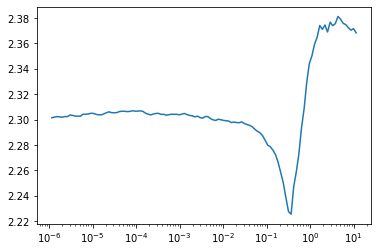

In [17]:
l_rate = learn.Learning_rate()
l_rate.find(lr_mod, lr_trldr,criterion, device, start_lr=1e-6, end_lr=1e1, cycle=1,
           target_callback = lambda x: x.long())
l_rate.plot_lr()

We pick the learning rate where the slope is the steepest.

#### Learn

In [18]:
metr = learn.fit(model, tr, 0.2, 8, criterion, device, optimiser='SGD',
                 valid_data=te, save_metrics=True, loading_bar=False, task='class',
                 target_callback = lambda x: x.long(),
                 one_cycle=False, w_decay=0.0001, 
                 multiple_categories=True
                )

1 loss: 0.0037  validation: 0.0033 accuracy 51.89% validation accuracy 84.57%
2 loss: 0.0030  validation: 0.0031 accuracy 92.69% validation accuracy 92.62%
3 loss: 0.0030  validation: 0.0030 accuracy 95.87% validation accuracy 96.94%
4 loss: 0.0029  validation: 0.0030 accuracy 96.92% validation accuracy 97.56%
5 loss: 0.0029  validation: 0.0030 accuracy 97.54% validation accuracy 98.00%
6 loss: 0.0029  validation: 0.0030 accuracy 97.86% validation accuracy 98.12%
7 loss: 0.0029  validation: 0.0030 accuracy 98.12% validation accuracy 98.16%
8 loss: 0.0029  validation: 0.0030 accuracy 98.17% validation accuracy 98.07%
Finished Training.


Validation accuracy is 98.07% after 8 epochs.